In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Comparing LSA, LDA, and NNMF

Now that you've been introduced to the logic behind these three topic extraction methods, we're going to try them out on the *Emma* corpus.  We'll be looking at interpretability, speed, and consistency across methods.  The goal is to identify common themes in *Emma* on a per-paragraph basis.  We won't be using pLSA as sklearn does not support it.

To do this, we will:

1. Parse and process the data into a tf-idf matrix.
2. Fit LSA, LDA, and NNMF models with 5 topics each.
4. Extract the words that best describe each topic.
5. Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'

## Generating the tfidf matrix

In [2]:
# Processing the data.

from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer


#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


In addition to creating the tfidf matrix, there are two convenience functions that will help keep the code tidy when comparing models.  The first provides a list of the words that are paired with each topic.  The second gives us the best words for each topic so we can compare across methods.

## Fitting the three topic extraction models

In [3]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
emma_paras_lsa = lsa.fit_transform(emma_paras_tfidf)

components_lsa = word_topic(emma_paras_tfidf, emma_paras_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                


In [4]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

emma_paras_lda = lda.fit_transform(emma_paras_tfidf) 

components_lda = word_topic(emma_paras_tfidf, emma_paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [5]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
emma_paras_nmf = nmf.fit_transform(emma_paras_tfidf) 

components_nmf = word_topic(emma_paras_tfidf, emma_paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

We are mostly using the default settings for each method, but explicitly printing them so it is clear what is going on and how each model can be modified.  sklearn has such nice parallel structure for its various topic extraction methods that we could probably have abstracted the code even further.

# Inspecting the topics

For each topic, we list the ten most-relevant words according to each method:

In [6]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])
    

Topic 0:
               LSA              LDA             NNMF
0         oh 97.61         mr 51.99         oh 30.12
0         yes 4.82       emma 49.89         yes 0.52
0       thank 1.58       said 39.52       sorry 0.16
0  difference 1.56        mrs 35.23  difference 0.15
0        just 1.44       miss 29.94        just 0.12
0     harriet 1.32    harriet 26.28        papa 0.12
0       sorry 1.28     weston 25.61        week 0.11
0       short 1.17  knightley 24.56       short 0.11
0        papa 1.15      elton 23.59    recollect 0.1
0   recollect 1.02        did 20.92      letter 0.09
Topic 1:
             LSA           LDA            NNMF
1     emma 58.27      oh 56.84         mr 7.29
1       mr 58.08      ah 18.12        mrs 4.26
1     said 50.66     emma 6.46      elton 3.41
1      mrs 47.07     said 4.87  knightley 3.24
1     miss 37.33   harriet 4.7     weston 3.15
1  harriet 34.77       mr 4.68       miss 2.99
1   weston 32.23  chapter 4.14  woodhouse 2.09
1    elton 27.76      m

A number of things are clear.  First, some topics are shared, though the order of topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA.  And second, the content of some of the topics varies considerably across methods.  This is a clear argument for using multiple methods when exploring topics.

# Sparsity

Now let's examine sparsity by looking at the distributions of loadings for the words 'marriage', 'love', 'emma', and 'oh' across the methods:

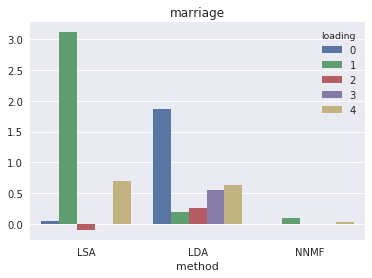

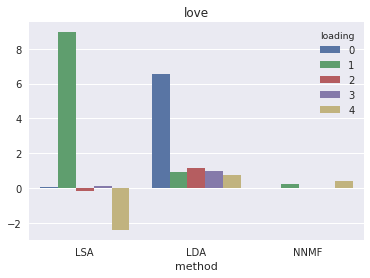

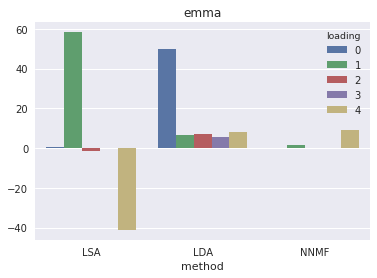

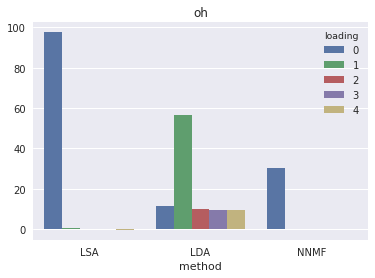

In [7]:
# The words to look at.
targetwords=['marriage','love','emma','oh']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


LSA is the method most likely to have high loadings on more than one topic for the same word.  LDA tends to have one high loading and some lower loadings.  Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.

# Challenge: Topic extraction on new data

Take the well-known [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset and use each of the methods on it.  Your goal is to determine which method, if any, best reproduces the topics represented by the newsgroups.  Write up a report where you evaluate each method in light of the 'ground truth'- the known source of each newsgroup post.  Which works best, and why do you think this is the case?



In [10]:
from sklearn.datasets import fetch_20newsgroups



In [11]:
from pprint import pprint
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [14]:
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
    print("%s: %s" % (category, " ".join(feature_names[top10])))

In [16]:
groups = ['rec.autos','rec.sport.hockey','sci.med','talk.politics.mideast']

### Newsgroups Used ###

* Let's concentrate on four newsgroups
    * Rec.Autos
    * Rec.sport.hockey
    * Sci.med
    * Talk.politics.mideast

In [17]:
ng_auto = fetch_20newsgroups(subset='train',
                             remove=('headers', 'footers', 'quotes'),
                             categories=['rec.autos'] )


In [48]:
ng_hockey = fetch_20newsgroups(subset='train',
                               remove=('headers', 'footers', 'quotes'),
                               categories=['rec.sport.hockey'] )

In [21]:
ng_med =    fetch_20newsgroups(subset='train',
                               remove=('headers', 'footers', 'quotes'),
                               categories=[groups[2]] )

In [22]:
ng_mideast = fetch_20newsgroups(subset='train',
                                remove=('headers', 'footers', 'quotes'),
                                categories=[groups[3]] )

In [39]:
vectorizer1 = TfidfVectorizer(stop_words='english')
vector_auto = vectorizer1.fit_transform(ng_auto.data)

vectorizer2 = TfidfVectorizer(stop_words='english')
vector_hockey = vectorizer2.fit_transform(ng_hockey.data)

vectorizer3 = TfidfVectorizer(stop_words='english')
vector_med = vectorizer3.fit_transform(ng_med.data)

vectorizer4 = TfidfVectorizer(stop_words='english')
vector_mideast = vectorizer4.fit_transform(ng_mideast.data)

## Comparing Models ##

### Rec.autos ###

In [40]:
# using LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
autos_lsa = lsa.fit_transform(vector_auto)

# Getting the word list.
terms = vectorizer1.get_feature_names()

auto_components_lsa = word_topic(vector_auto, autos_lsa, terms)

topwords_auto=pd.DataFrame()
topwords_auto['LSA']=top_words(auto_components_lsa, n_top_words)                

In [41]:
# using LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

autos_lda = lda.fit_transform(vector_auto) 

components_lda = word_topic(vector_auto, autos_lda, terms)

topwords_auto['LDA']=top_words(components_lda, n_top_words)


/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [42]:
# using NNMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
autos_nmf = nmf.fit_transform(vector_auto) 

components_nmf = word_topic(vector_auto, autos_nmf, terms)

topwords_auto['NNMF']=top_words(components_nmf, n_top_words)


### Inspecting Topics in Rec.autos ###

In [43]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords_auto.loc[topic])

Topic 0:
          LSA               LDA        NNMF
0   car 15.88         ites 0.98  speed 0.57
0    like 9.5          car 0.77    car 0.55
0    just 8.5      archive 0.48  drive 0.49
0   cars 7.73  continental 0.48   cars 0.47
0   good 7.01           gt 0.46   just 0.47
0    new 6.99         like 0.45  right 0.43
0    know 6.5          ibm 0.39    like 0.4
0    don 6.47          5sp 0.39    road 0.4
0  think 5.63       server 0.38   auto 0.39
0   does 5.16        catch 0.38    sho 0.36
Topic 1:
               LSA           LDA                NNMF
1          __ 3.28       __ 1.74             __ 2.08
1       _____ 1.28  deleted 1.06          _____ 0.82
1         ___ 1.23    stuff 0.94            ___ 0.74
1        ____ 0.86    _____ 0.69        _______ 0.55
1     _______ 0.85      ___ 0.62           ____ 0.52
1      wouldn 0.73      car 0.62            16v 0.27
1  understand 0.55     ditto 0.6             oo 0.27
1        need 0.54      like 0.5           ncsl 0.27
1         keys 0.5  _

### Rec.sport.hockey ###

In [55]:
vectorizer2 = TfidfVectorizer(stop_words='english')
vector_hockey = vectorizer2.fit_transform(ng_hockey.data)

In [56]:
# using LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
hockey_lsa = lsa.fit_transform(vector_hockey)

# Getting the word list.
terms2 = vectorizer2.get_feature_names()

hockey_components_lsa = word_topic(vector_hockey, hockey_lsa, terms2)

topwords_hockey=pd.DataFrame()
topwords_hockey['LSA']=top_words(hockey_components_lsa, n_top_words)                

In [59]:
# using LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

hockey_lda = lda.fit_transform(vector_hockey) 

hockey_components_lda = word_topic(vector_hockey, hockey_lda, terms2)

topwords_hockey['LDA']=top_words(hockey_components_lda, n_top_words)

/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [60]:
# using NNMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
hockey_nmf = nmf.fit_transform(vector_hockey) 

components_nmf = word_topic(vector_hockey, hockey_nmf, terms2)

topwords_hockey['NNMF']=top_words(components_nmf, n_top_words)


### Inspecting Topics in Rec.sport.hockey ###

In [61]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords_hockey.loc[topic])

Topic 0:
           LSA             LDA          NNMF
0   game 12.75      rectum 0.6     game 1.26
0   team 11.46       game 0.48     team 1.14
0  hockey 9.74     assume 0.44   hockey 1.03
0   games 8.67  sarcastic 0.42  players 0.98
0     don 8.41       team 0.41   season 0.85
0   think 8.24     remark 0.41      don 0.81
0  season 8.24      vielen 0.4    think 0.79
0    play 8.14        dank 0.4     play 0.77
0    year 7.97        just 0.4    games 0.76
0    just 7.95  desperate 0.38     like 0.76
Topic 1:
           LSA           LDA         NNMF
1  period 3.02   colons 0.48  period 1.33
1      10 2.98     game 0.48      10 1.12
1     pts 2.77  florida 0.39      pp 1.04
1      11 2.77     team 0.38      11 1.01
1      pp 2.35    south 0.37     pts 0.92
1      12 2.22   hockey 0.37      12 0.81
1      55 2.02     just 0.36   power 0.76
1      18 1.84    games 0.32  scorer 0.68
1      19 1.75     like 0.31      18 0.66
1      15 1.71    think 0.31    play 0.62
Topic 2:
            LSA 

### Sci.med ###

In [62]:
vectorizer3 = TfidfVectorizer(stop_words='english')
vector_med = vectorizer3.fit_transform(ng_med.data)

In [63]:
# using LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
med_lsa = lsa.fit_transform(vector_med)

# Getting the word list.
terms3 = vectorizer3.get_feature_names()

med_components_lsa = word_topic(vector_med, med_lsa, terms3)

topwords_med=pd.DataFrame()
topwords_med['LSA']=top_words(med_components_lsa, n_top_words)                

In [64]:
# using LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

med_lda = lda.fit_transform(vector_med) 

med_components_lda = word_topic(vector_med, med_lda, terms3)

topwords_med['LDA']=top_words(med_components_lda, n_top_words)

/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [65]:
# using NNMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
med_nmf = nmf.fit_transform(vector_med) 

components_nmf = word_topic(vector_med, med_nmf, terms3)

topwords_med['NNMF']=top_words(components_nmf, n_top_words)


### Inspecting Topics in Sci.med ###

In [66]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords_med.loc[topic])

Topic 0:
             LSA               LDA             NNMF
0        edu 9.1         know 0.38       cadre 2.03
0       geb 8.39      britain 0.35         dsl 2.03
0     banks 8.34          edu 0.32    shameful 2.03
0      pitt 8.32  information 0.31   surrender 2.03
0    gordon 8.25           msg 0.3         geb 2.03
0        dsl 8.2          don 0.29       n3jxp 2.03
0   shameful 8.2          geb 0.28    chastity 2.03
0      cadre 8.2        banks 0.28   intellect 2.03
0  surrender 8.2       gordon 0.28  skepticism 2.02
0     n3jxp 8.19         pitt 0.28        pitt 2.01
Topic 1:
           LSA          LDA         NNMF
1    know 6.88    know 0.34    pain 1.31
1     msg 6.22    like 0.33  doctor 0.89
1     don 6.14     edu 0.32  clinic 0.47
1  people 6.12   memes 0.32     don 0.37
1    like 5.58      msg 0.3    said 0.33
1    just 4.96     don 0.29    told 0.33
1    does 4.92     geb 0.28   doesn 0.32
1    think 4.9   banks 0.28    time 0.28
1    food 4.89  gordon 0.28    like 0.27


### Talk.politics.mideast ###

In [67]:
vectorizer4 = TfidfVectorizer(stop_words='english')
vector_mideast = vectorizer4.fit_transform(ng_mideast.data)

In [68]:
# using LSA

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
mideast_lsa = lsa.fit_transform(vector_mideast)

# Getting the word list.
terms4 = vectorizer4.get_feature_names()

mideast_components_lsa = word_topic(vector_mideast, mideast_lsa, terms4)

topwords_mideast=pd.DataFrame()
topwords_mideast['LSA']=top_words(mideast_components_lsa, n_top_words)          

In [69]:
# using LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

mideast_lda = lda.fit_transform(vector_mideast) 

mideast_components_lda = word_topic(vector_mideast, mideast_lda, terms4)

topwords_mideast['LDA']=top_words(mideast_components_lda, n_top_words)

/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/home/ljagged/miniconda3/envs/thinkful/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [70]:
# using NNMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
mideast_nmf = nmf.fit_transform(vector_mideast) 

components_nmf = word_topic(vector_mideast, mideast_nmf, terms4)

topwords_mideast['NNMF']=top_words(components_nmf, n_top_words)


### Inspecting Topics in Talk.politics.mideast ###

In [71]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords_mideast.loc[topic])

Topic 0:
              LSA             LDA           NNMF
0    israel 12.05      loser 0.52    israel 2.12
0     people 9.65    asshole 0.51   israeli 1.26
0    israeli 8.59     pollard 0.5      arab 0.85
0       jews 8.12     israel 0.48      jews 0.82
0   armenian 7.72       jerk 0.45  lebanese 0.62
0  armenians 7.09    nursery 0.45     arabs 0.55
0       just 6.91     shrink 0.42   lebanon 0.54
0    turkish 6.53  definetly 0.42     peace 0.51
0       said 6.29        john 0.4  israelis 0.49
0       arab 6.26      cases 0.38     state 0.48
Topic 1:
              LSA               LDA            NNMF
1   armenian 6.31      retarded 1.3   armenian 2.48
1  armenians 5.22       israel 0.48  armenians 1.69
1    turkish 4.67    delightful 0.4    turkish 1.36
1    armenia 2.81         just 0.39   genocide 1.19
1   genocide 2.74          hey 0.38     people 0.93
1     turkey 2.52          did 0.38     soviet 0.87
1      turks 2.37  interesting 0.36    armenia 0.81
1     serdar 2.13       kin

## Discussion ##

We have taken the 20 Newsgroups dataset in order to further test
topic extraction using LSA, LDA, and NNMF. I conduct an investigation
into each method by running topic extraction on four of the newsgroups.
The selected newsgroups are rec.autos, rec.sport.hockey, sci.med, and
talk.politics.mideast. Each of these newsgroups deals with quite separate
and highly distinguishable topics.  Rec.autos deals with automotive issues
such as car makes and models and driving experiences.  Rec.sports.hockey deals
with hockey issues (the teams and specific games) obviously.  Sci.med is a broad
based medical newsgroup and the topics should be relating to health issues and
diseases and conditions related to human medical matters.  Talk.politics.mideast
is a rather self explanatory newsgroup that would most likely to dealing with
the countries of the mideast and issues such as wars and confict of that region.

The results of topic extraction for rec.auto is informative. Topic 0 from both
LSA and NNMF display words like car, cars, road, speed, auto and drive.  NNMF
has the most topical with LSA close behind.  LDA contains car but little else.
Topic 2 has almost identical results for LSA and NNMF containing more complex
issues like insurance, saturn, price and dealer while LDA has only simpler words
like cars, engine and new.  The general appearance of the topic in rec.auto
appears to be that LSA and NNMF are quite similar and contain a greater variety
of complex on-topic automotive ideas and LDA seems to be rather lacking in this regard.

This pattern recurs with the rest of the newsgroups in general.  LSA and NNMF
generally find keywords that are on target to the ground truth on the newsgroup.  
LDA can often find the most obvious high level words such as israel and arab in talk.politics.mideast but often contains garbled or off-topic words or overly 
elaborate words such contaminants in sci.med that do not hold to a coherent topic.  

From the experience using these algorithms, I feel compelled to say that LDA
was overall the worst performing algorithm of the three.  It often fixated on
strange vocabulary that was almost always off-topic.  NNMF and LSA can both 
be relied upon to exract keyword topics that make good intuitive sense.